observation space, action space가 discrete인지 continuous인지에 따라 사용할 수 있는 강화학습 알고리즘이 다름

|                   |state     |action    |
|-------------------|----------|----------|
|Q-learning(tabulo) |discrete  |discrete  |
|Q-learning(network)|continuous|discrete  |

하지만 bipedal enviornment는 둘 모두 continuous라서 Q-learning을 사용할 수 없다.

따라서 성능이 안좋게 나올 것을 감안하고 action space를 양자화하여 16개의 discrete환경으로 바꿔 풀어보려 한다.

07-ddqn-bipedal에서 성능이 잘 나오지 않아 dueling ddqn을 적용해보고자 한다

In [1]:
import gymnasium
import torch
import numpy as np
import random
import itertools
import math
import copy
import collections
from tqdm import tqdm

In [3]:
class QNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
        )
        self.value = torch.nn.Linear(32, 1, bias=False)
        self.advantage = torch.nn.Linear(32, output_size, bias=False)
    
    def forward(self, x):
        x = self.encoder(x)
        v = self.value(x[..., :32])
        a = self.advantage(x[..., 32:])
        return v + a - a.mean(-1, keepdim=True)

class Agent:
    def __init__(self, input_size, output_size, lr, tau, gamma):
        self.count = 0
        self.q = QNetwork(input_size, output_size)
        self.target_q = copy.deepcopy(self.q).requires_grad_(False)
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q.parameters(), lr=lr)
        self.tau = tau
        self.gamma = gamma
    
    def _action_to_num(self, action):
        action = np.where(action > 0, 1, 0)
        return (action * [8, 4, 2, 1]).sum(-1)

    def _action_to_array(self, action):
        action = np.array(action) // [8, 4, 2, 1] % 2
        return np.where(action, 0.5, -0.5)
    
    def sample(self, state, target=False):
        net = self.target_q if target else self.q
        action = net(torch.tensor(state)).argmax(-1).cpu().detach().item()
        return self._action_to_array(action)
    
    def update(self, batch):
        actions = torch.tensor(self._action_to_num(batch.action))
        state_action_values = self.q(batch.state).gather(1, actions.unsqueeze(1)).squeeze()
        next_state_values = torch.zeros_like(state_action_values)
        next_actions = self.q(batch.next_state[~batch.terminated]).max(1).indices
        next_state_values[~batch.terminated] = self.target_q(batch.next_state[~batch.terminated]).gather(1, next_actions.unsqueeze(1)).squeeze()
        expect_state_action_values = batch.reward + self.gamma * next_state_values
        loss = self.criterion(state_action_values, expect_state_action_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        target_q_state_dict = self.target_q.state_dict()
        q_state_dict = self.q.state_dict()
        for key in q_state_dict:
            target_q_state_dict[key] = (1 - self.tau) * target_q_state_dict[key] + (self.tau) * q_state_dict[key]
        self.target_q.load_state_dict(target_q_state_dict)

class EGreedySampler:
    def __init__(self, agent, env, eps_start=0.9, eps_end=0.05, eps_decay=1000):
        self.agent = agent
        self.env = env
        self.count = 0
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
    
    def sample(self, state):
        eps = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-self.count / self.eps_decay)
        self.count += 1
        if random.random() < eps:
            return self.env.action_space.sample()
        return self.agent.sample(state)

class ReplayBuffer:
    Transition = collections.namedtuple('Transition', 'state action reward next_state terminated')
    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)
    
    def __repr__(self):
        return repr(self.memory)
    
    def append(self, state, action, reward, next_state, terminated):
        self.memory.append(self.Transition(
            np.array(state, dtype=np.float32),
            np.array(action, dtype=np.float32),
            np.array(reward, dtype=np.float32),
            np.array(next_state, dtype=np.float32),
            np.array(terminated, dtype=np.bool8)
        ))

    def sample(self, batch_size):
        return self.Transition(*(torch.tensor(np.array(i)) for i in zip(*random.sample(self.memory, batch_size))))
    
env = gymnasium.make('BipedalWalker-v3')
agent = Agent(env.observation_space.shape[0], 2 ** env.action_space.shape[0], 0.0001, 0.005, 0.99)
action_sampler = EGreedySampler(agent, env)
replay_buffer = ReplayBuffer(10000)

In [4]:
num_episode = 600
batch_size = 128
scores = []
for i in tqdm(range(num_episode)):
    state, info = env.reset()
    score = 0
    for step in itertools.count():
        action = action_sampler.sample(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        score += reward
        replay_buffer.append(state, action, reward, next_state, terminated)
        if len(replay_buffer) >= batch_size:
            batch = replay_buffer.sample(batch_size)
            agent.update(batch)
        if terminated or truncated:
            break
    scores.append(score)
    if (i + 1) % 100 == 0:
        print(np.mean(scores[-100:]))

 17%|█▋        | 100/600 [07:46<1:12:44,  8.73s/it]

-109.23914807577243


 33%|███▎      | 200/600 [17:27<09:13,  1.38s/it]  

-105.45150543184756


 50%|█████     | 300/600 [27:34<1:11:16, 14.26s/it]

-105.58003000748627


 67%|██████▋   | 400/600 [38:38<22:10,  6.65s/it]  

-107.97148049345613


 83%|████████▎ | 500/600 [58:38<32:03, 19.23s/it]  

-106.27132315126173


100%|██████████| 600/600 [1:18:01<00:00,  7.80s/it]

-103.17463132844814


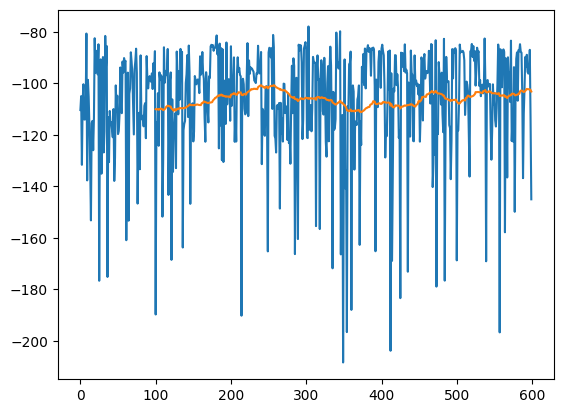

In [5]:
import matplotlib.pyplot as plt
plt.plot(scores)
smooth_size = 100
scores_smooth = []
scores_sum = sum(scores[:smooth_size])
for i in range(len(scores) - smooth_size):
    scores_sum += scores[i + smooth_size] - scores[i]
    scores_smooth.append(scores_sum / smooth_size)
plt.plot(range(smooth_size, len(scores)), scores_smooth)

In [6]:
env = gymnasium.make('BipedalWalker-v3', render_mode='human')
valid_scores = []
for i in range(10):
    score = 0
    state, info = env.reset()
    while True:
        action = agent.sample(state, target=True)
        next_state, reward, terminated, truncated, info = env.step(action)
        score += reward
        state = next_state
        if terminated or truncated:
            break
    valid_scores.append(score)
env.close()
valid_scores

[-100.80523124431322,
 -100.68580446075089,
 -100.7788768904383,
 -100.94954955827197,
 -100.69806085225257,
 -100.80666994599378,
 -100.82012276926761,
 -100.69545311706824,
 -100.83160469581125,
 -100.80152665816931]

In [7]:
env.close()